In [1]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import Imputer
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import cross_val_score 
from xgboost.sklearn import XGBClassifier

In [2]:
data_train = pd.read_csv('../input/train.csv')
data_test = pd.read_csv('../input/test.csv')
target = data_train.Survived
data_all = pd.concat([data_train.drop(['Survived'], axis=1), data_test])
for column in data_all.columns:
    print('Column: ', column, ' contain nan: ', data_all[column].isna().any())

Column:  PassengerId  contain nan:  False
Column:  Pclass  contain nan:  False
Column:  Name  contain nan:  False
Column:  Sex  contain nan:  False
Column:  Age  contain nan:  True
Column:  SibSp  contain nan:  False
Column:  Parch  contain nan:  False
Column:  Ticket  contain nan:  False
Column:  Fare  contain nan:  True
Column:  Cabin  contain nan:  True
Column:  Embarked  contain nan:  True


In [3]:
"""
This part use to process Age column in data,
Age data may be nan, we use the NameTitle 
to handle it
"""
def construct_name_title_age_map(data):
    _data = pd.DataFrame.copy(data)
    _data['NameTitle'] = _data.Name.apply(lambda name: re.findall(r'.+, (\w+). .+', name)[0])
    titles = _data.NameTitle.unique()
    title_group = _data.groupby('NameTitle')
    return {title: title_group.get_group(title).Age.mean().astype(int) for title in titles}

def fix_age_using_name_title(data, title_age_map):
    _data = pd.DataFrame.copy(data)
    _data['NameTitle'] = _data.Name.apply(lambda name: re.findall(r'.+, (\w+). .+', name)[0])
    for title, mage in title_age_map.items():
        _data.loc[(_data.Age.isna().any()) & (_data.NameTitle == title), 'Age'] = mage
    return _data

        
# name_title_age_map = construct_name_title_age_map(data_all)
# Following use to fix data's missing Age with mean age of the same title
# tmp = fix_age_using_name_title(data_train, name_title_age_map)
# g = sns.FacetGrid(data_train, col='Survived')
# g = g.map(sns.distplot, "Age")

def convert_age(data):
    dists = range(0, 85, 5)
    def map_age_to_dist(age):
        i = 0
        while i < len(dists) - 1:
            if dists[i+1] > age > dists[i]:
                return i
            i += 1
        return dists[i]
    _data = pd.DataFrame.copy(data)
    _data.Age = _data.Age.apply(map_age_to_dist)
    return _data

def process_age(data, title_to_age):
    return convert_age(fix_age_using_name_title(data, title_to_age))

In [4]:
"""
This part use to convert Sex to numerical value
"""
def convert_sex(data):
    """Convert Sex"""
    sex_map = {'male': 0, 'female': 1}
    _data = pd.DataFrame.copy(data)
    _data.Sex = _data.Sex.apply(lambda sex: sex_map[sex])
    return _data

def process_sex(data):
    return convert_sex(data)

In [5]:
"""
This part use to convert Embarked to numerical value
Embarked value may be nan, we fix it with mean value of Embarked
"""
def convert_embarked(data):
    """Convert Embarked"""
    dic = {'S': 0, 'C': 1, 'Q': 2}
    _data = pd.DataFrame.copy(data)
    _data.Embarked = _data.Embarked.apply(lambda embarked: dic.get(embarked, embarked))
    return _data

def fix_nan_embarked(data):
    _data = pd.DataFrame.copy(data)
    _data.Embarked = _data.Embarked.apply(lambda embarked: _data.Embarked.mean() if pd.isna(embarked) else embarked)
    return _data

def process_embarked(data):
    return fix_nan_embarked(convert_embarked(data))

In [6]:
"""
This part use to construct new column FamilySize  using
SibSp & Parch columns
"""
def construct_family_size(data):
    """Construct FamilySize"""
    _data = pd.DataFrame.copy(data)
    _data['FamilySize'] = data.SibSp + data.Parch + 1
    return _data

def process_family_size(data):
    return construct_family_size(data)

In [7]:
"""
This part use to process Cabin column
First we build cabin map for convert categorical to numerical
Then we need to handle nan value with Pclass column in data
"""
def extract_cabin_prefix(cabin):
    return cabin.strip()[0] if not pd.isna(cabin) else cabin

def construct_cabin_map(data):
    _data = pd.DataFrame.copy(data)
    cabin = _data.Cabin.apply(extract_cabin_prefix)
    return {  p: i for i, p in enumerate(cabin.unique()) if not pd.isna(p)}

cabin_map = construct_cabin_map(data_all)

def construct_pclass_cabin_map(data):
    _data = pd.DataFrame.copy(data)
    _data.Cabin = _data.Cabin.apply(extract_cabin_prefix)
    group = _data.groupby('Pclass')
    return { pcls: group.get_group(pcls).Cabin.value_counts().index[0] for pcls in  group.groups.keys()}

pclass_cabin_map = construct_pclass_cabin_map(data_all)

def fix_nan_cabin(data, pclass_cabin_map):
    _data = pd.DataFrame.copy(data)
    _data.Cabin = _data.Cabin.apply(extract_cabin_prefix)
    for pclass, mcabin in pclass_cabin_map.items():
        _data.loc[(_data.Cabin.isna().any()) & (_data.Pclass == pclass), 'Cabin'] = mcabin
    return _data

def convert_cabin(data):
    dic = construct_cabin_map(data)
    _data = pd.DataFrame.copy(data)
    _data.Cabin = _data.Cabin.apply(lambda cabin: dic.get(cabin, cabin))
    return _data
    

def process_cabin(data, pclass_to_cabin):
    return convert_cabin(fix_nan_cabin(data, pclass_to_cabin))

/home/jferroal/.venvs/lite_data_science/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


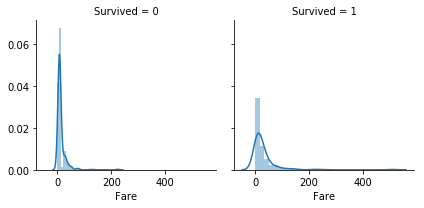

In [8]:
"""
This part use to process Fare column in data  
First we will calculate the mean Fare for each passenger,
we did this cause in data we can found that the Fare of each 
passenger is the total cost of their family, so we would divide 
Fare with FamilySize
Then, we need to fix nan value in Fare, in general, the fare is 
depend on user's Pclass and Cabin, but we can see from above,
Cabin has lots of nan value, so Pclass is better for us
At last, we would convert Fare to dist
"""
def calc_mean_fare(data):
    _data = pd.DataFrame.copy(data)
    _data.Fare = _data.Fare / _data.FamilySize
    return _data

def construct_pclass_fare_map(data):
    _data = calc_mean_fare(data)
    group = _data.groupby('Pclass')
    return {pcls: group.get_group(pcls).Fare.mean() for pcls in group.groups.keys()}

def fix_missing_fare(data, pclass_fare_map):
    """Fix missing price value"""
    _data = calc_mean_fare(data)
    for pcls, mfare in pclass_fare_map.items():
        _data.loc[(_data.Fare.isna().any()) & (_data.Pclass == pcls), 'Fare'] = mfare
    return _data

def convert_fare_to_dist(data):
    dists = [0, 10, 20, 30, 50, 100, 200]
    def map_fare_to_dist(age):
        i = 0
        while i < len(dists) - 1:
            if dists[i+1] > age > dists[i]:
                return i
            i += 1
        return dists[i]
    _data = pd.DataFrame.copy(data)
    _data.Fare = _data.Fare.apply(map_fare_to_dist)
    return _data
    

tmp_all = construct_family_size(data_all)
tmp_train = construct_family_size(data_train)
pclass_fare_map = construct_pclass_fare_map(tmp_all)
tmp = fix_missing_fare(tmp_train, pclass_fare_map)
g = sns.FacetGrid(tmp, col='Survived')
g = g.map(sns.distplot, "Fare", bins=30)
convert_fare_to_dist(tmp)

def process_fare(data, pclass_to_fare):
    return convert_fare_to_dist(fix_missing_fare(data, pclass_to_fare))

In [53]:
def drop_unnecessary(data):
    return data.drop(['Ticket', 'Name', 'NameTitle', 'SibSp', 'Parch', 'PassengerId'], axis=1)

In [54]:
# process data all
All = construct_family_size(data_all)
Name_Title_To_Mean_Age = construct_name_title_age_map(All)
Pclass_To_Mean_Fare = construct_pclass_fare_map(All)
Pclass_To_Most_Cabin = construct_pclass_cabin_map(All)

X_train = process_age(data_train, Name_Title_To_Mean_Age)
X_train = process_sex(X_train)
X_train = process_embarked(X_train)
X_train = process_family_size(X_train)
X_train = process_cabin(X_train, Pclass_To_Most_Cabin)
X_train = process_fare(X_train, Pclass_To_Mean_Fare)
X_train = drop_unnecessary(X_train)
y_train = X_train.Survived
X_train = X_train.drop(['Survived'], axis=1)
X_train

,Pclass,Sex,Age,Fare,Cabin,Embarked,FamilySize
0,3,0,6,0,0,0.0,2
1,1,1,7,3,1,1.0,2
2,3,1,4,0,0,0.0,1
3,1,1,7,2,1,0.0,2
4,3,0,6,0,0,0.0,1
5,3,0,6,0,0,2.0,1
6,1,0,6,4,1,0.0,1
7,3,0,80,0,0,0.0,5
8,3,1,7,0,0,0.0,3
9,2,1,7,1,0,1.0,2


In [55]:
X_test = process_age(data_test, Name_Title_To_Mean_Age)
X_test = process_sex(X_test)
X_test = process_embarked(X_test)
X_test = process_family_size(X_test)
X_test = process_cabin(X_test, Pclass_To_Most_Cabin)
X_test = process_fare(X_test, Pclass_To_Mean_Fare)
X_test = drop_unnecessary(X_test)

In [56]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

In [57]:
kfold = StratifiedKFold(n_splits=10)

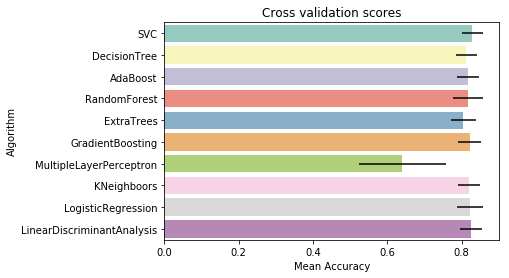

In [58]:
# Modeling step Test differents algorithms 
random_state = 2
svc_model = SVC(random_state=random_state)
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state), random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())

cv_results = []

for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y = y_train, scoring = "accuracy", cv = kfold, n_jobs=4))
    

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({
    'CrossValMeans': cv_means,
    'CrossValerrors': cv_std,
    'Algorithm':[
        'SVC',
        'DecisionTree',
        'AdaBoost',
        'RandomForest',
        'ExtraTrees',
        'GradientBoosting',
        'MultipleLayerPerceptron',
        'KNeighboors',
        'LogisticRegression',
        'LinearDiscriminantAnalysis'
    ]
})

g = sns.barplot('CrossValMeans', 'Algorithm', data = cv_res, palette='Set3', orient = 'h', **{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")
# use LDA, LR, GB, ET, RF

In [59]:
svc = SVC(probability=True)
svc_param_grid = {'kernel': ['rbf'], 
                  'gamma': [ 0.001, 0.01, 0.1, 1],
                  'C': [1, 10, 50, 100,200,300, 1000]}

gssvc = GridSearchCV(svc,param_grid = svc_param_grid, cv=kfold, scoring="accuracy", n_jobs= 8, verbose = 1)

gssvc.fit(X_train, y_train)

svc_best = gssvc.best_estimator_

# Best score
gssvc.best_score_

Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=8)]: Done  52 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done 280 out of 280 | elapsed:    9.3s finished


0.835016835016835

In [60]:
gb = GradientBoostingClassifier()
gb_param_grid = {
    'loss' : ["deviance"],
    'n_estimators' : [20, 50, 75, 100,150, 200,300],
    'learning_rate': [1, 0.8, 0.65, 0.5, 0.3,0.1, 0.05, 0.01],
    'max_depth': [1, 3, 5],
    'min_samples_leaf': [20, 50, 100, 200],
    'max_features': [1, 0.75, 0.5, 0.1, 0.05, 0.01] 
}

gsgb = GridSearchCV(gb, param_grid=gb_param_grid, cv=kfold, scoring="accuracy", n_jobs= 8, verbose = 1)

gsgb.fit(X_train, y_train)

gb_best = gsgb.best_estimator_

# Best score
gsgb.best_score_

Fitting 10 folds for each of 4032 candidates, totalling 40320 fits


[Parallel(n_jobs=8)]: Done 232 tasks      | elapsed:    2.1s
[Parallel(n_jobs=8)]: Done 1954 tasks      | elapsed:   17.7s
[Parallel(n_jobs=8)]: Done 3460 tasks      | elapsed:   37.4s
[Parallel(n_jobs=8)]: Done 4720 tasks      | elapsed:   55.9s
[Parallel(n_jobs=8)]: Done 6070 tasks      | elapsed:  1.2min
[Parallel(n_jobs=8)]: Done 7720 tasks      | elapsed:  1.5min
[Parallel(n_jobs=8)]: Done 9670 tasks      | elapsed:  2.0min
[Parallel(n_jobs=8)]: Done 11920 tasks      | elapsed:  2.4min
[Parallel(n_jobs=8)]: Done 14470 tasks      | elapsed:  3.0min
[Parallel(n_jobs=8)]: Done 17320 tasks      | elapsed:  3.5min
[Parallel(n_jobs=8)]: Done 20470 tasks      | elapsed:  4.3min
[Parallel(n_jobs=8)]: Done 23920 tasks      | elapsed:  5.0min
[Parallel(n_jobs=8)]: Done 27670 tasks      | elapsed:  5.7min
[Parallel(n_jobs=8)]: Done 31720 tasks      | elapsed:  6.5min
[Parallel(n_jobs=8)]: Done 35040 tasks      | elapsed:  7.7min
[Parallel(n_jobs=8)]: Done 38140 tasks      | elapsed:  8.5min


0.8372615039281706

In [61]:
kn = KNeighborsClassifier()
kn_param_grid = {}

gskn = GridSearchCV(kn, param_grid = kn_param_grid, cv=kfold, scoring="accuracy", n_jobs= 8, verbose = 1)

gskn.fit(X_train, y_train)

kn_best = gskn.best_estimator_

# Best score
gskn.best_score_

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished


0.819304152637486

In [62]:
lr = LogisticRegression()
lr_param_grid = {
    'penalty': ['l2'],
    'solver': ['newton-cg', 'lbfgs', 'sag'],
    'multi_class': ['multinomial', 'ovr'],
    'class_weight': ['balanced']
}
gslr = GridSearchCV(lr, param_grid=lr_param_grid, cv=kfold, scoring="accuracy", n_jobs= 8, verbose = 1)

gslr.fit(X_train,y_train)

lr_best = gslr.best_estimator_
gslr.best_score_

Fitting 10 folds for each of 6 candidates, totalling 60 fits


/home/jferroal/.venvs/lite_data_science/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/jferroal/.venvs/lite_data_science/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/jferroal/.venvs/lite_data_science/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/jferroal/.venvs/lite_data_science/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/jferroal/.venvs/lite_data_science/lib/python3.

0.8013468013468014

In [63]:
lda = LinearDiscriminantAnalysis()
lda_param_grid = {
    'solver': ['lsqr', 'eigen'],
    'shrinkage': [0, 0.01, 0.05, 0.1, 0.2, 0.5, 0.75, 1],
}
gslda = GridSearchCV(lda, param_grid=lda_param_grid, cv=kfold, scoring="accuracy", n_jobs= 8, verbose = 1)

gslda.fit(X_train,y_train)

lda_best = gslda.best_estimator_

gslda.best_score_

Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=8)]: Done 160 out of 160 | elapsed:    0.4s finished


0.8249158249158249

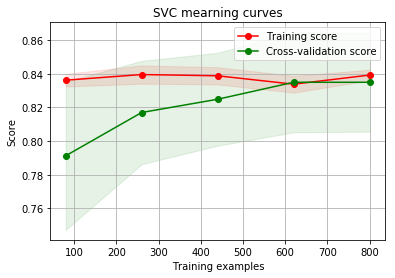

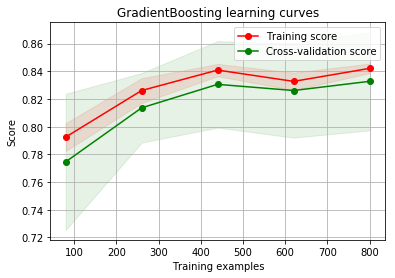

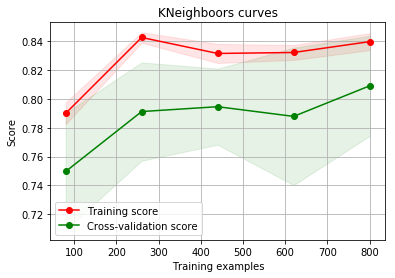

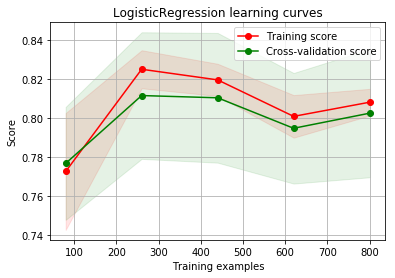

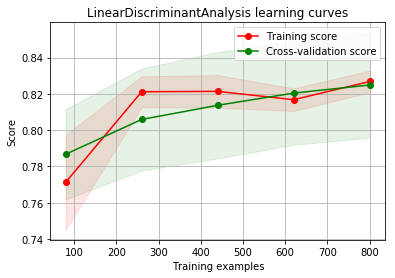

In [64]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

g = plot_learning_curve(gssvc.best_estimator_,"SVC mearning curves",X_train, y_train,cv=kfold)
g = plot_learning_curve(gsgb.best_estimator_,"GradientBoosting learning curves",X_train, y_train,cv=kfold)
g = plot_learning_curve(gskn.best_estimator_,"KNeighboors curves",X_train,y_train,cv=kfold)
g = plot_learning_curve(gslr.best_estimator_,"LogisticRegression learning curves",X_train, y_train,cv=kfold)
g = plot_learning_curve(gslda.best_estimator_,"LinearDiscriminantAnalysis learning curves",X_train, y_train,cv=kfold)

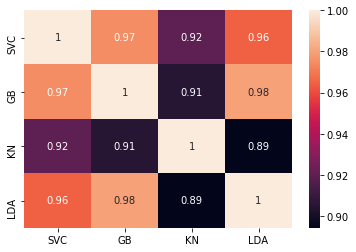

In [39]:
test_Survived_svc = pd.Series(svc_best.predict(X_test), name="SVC")
test_Survived_gb = pd.Series(gb_best.predict(X_test), name="GB")
test_Survived_kn = pd.Series(kn_best.predict(X_test), name="KN")
test_Survived_lda = pd.Series(lda_best.predict(X_test), name="LDA")


# Concatenate all classifier results
ensemble_results = pd.concat([
    test_Survived_svc,
    test_Survived_gb,
    test_Survived_kn,
    test_Survived_lda
], axis=1)


g= sns.heatmap(ensemble_results.corr(),annot=True)

In [65]:
DTC = DecisionTreeClassifier()

adaDTC = AdaBoostClassifier(DTC, random_state=7)

ada_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "algorithm" : ["SAMME","SAMME.R"],
              "n_estimators" :[1, 2],
              "learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]}

gsadaDTC = GridSearchCV(adaDTC,param_grid = ada_param_grid, cv=kfold, scoring="accuracy", n_jobs= 8, verbose = 1)

gsadaDTC.fit(X_train,y_train)

ada_best = gsadaDTC.best_estimator_
gsadaDTC.best_score_

Fitting 10 folds for each of 112 candidates, totalling 1120 fits


[Parallel(n_jobs=8)]: Done 376 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done 1120 out of 1120 | elapsed:    1.5s finished


0.8148148148148148

In [66]:
#ExtraTrees 
ExtC = ExtraTreesClassifier()


## Search grid for optimal parameters
ex_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 5, 7],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,150, 300],
              "criterion": ["gini"]}


gsExtC = GridSearchCV(ExtC,param_grid = ex_param_grid, cv=kfold, scoring="accuracy", n_jobs= 8, verbose = 1)

gsExtC.fit(X_train,y_train)

ExtC_best = gsExtC.best_estimator_

# Best score
gsExtC.best_score_

Fitting 10 folds for each of 108 candidates, totalling 1080 fits


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.8s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    9.2s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:   23.9s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:   45.6s
[Parallel(n_jobs=8)]: Done 1080 out of 1080 | elapsed:  1.1min finished


0.8294051627384961

In [67]:
RFC = RandomForestClassifier()


## Search grid for optimal parameters
rf_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 5, 7],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100, 150, 300],
              "criterion": ["gini"]}


gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= 8, verbose = 1)

gsRFC.fit(X_train,y_train)

RFC_best = gsRFC.best_estimator_

# Best score
gsRFC.best_score_

Fitting 10 folds for each of 108 candidates, totalling 1080 fits


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.9s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   10.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:   25.4s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:   49.9s
[Parallel(n_jobs=8)]: Done 1080 out of 1080 | elapsed:  1.2min finished


0.8305274971941639

In [68]:
votingC = VotingClassifier(
    estimators=[
        ('svc', svc_best), 
        ('gb', gb_best),
        ('rfc', RFC_best), 
        ('ext', ExtC_best),
        ('lda', lda_best)
    ], voting='soft', n_jobs=8)

votingC = votingC.fit(X_train, y_train)

In [69]:
prediction = pd.Series(votingC.predict(X_test), name="Survived")

result = pd.concat([data_test.PassengerId, prediction], axis=1)

result.to_csv("fourth_submission.csv", index=False)

/home/jferroal/.venvs/lite_data_science/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
